In [1]:
%matplotlib inline

# API Reference: http://graylab.jhu.edu/pyrosetta/downloads/documentation/pyrosetta4_online_format/PyRosetta4_Workshops_Appendix_A.pdf
import pyrosetta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pyrosetta.init()

Found rosetta database at: /Users/sanyamkapoor/Workspace/mlenv/lib/python3.6/site-packages/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python36.mac 2018.13+release.e0d86740ed3e0d86740ed30e28fc16f36793f608bbc5ce7eaf9 2018-03-31T08:07:21] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python36.mac r175 2018.13+release.e0d86740ed3 e0d86740ed30e28fc16f36793f608bbc5ce7eaf9 http://www.pyrosetta.org 2018-03-31T08:07:21
core.init: command: PyRosetta -ex1 -ex2aro -database /Users/sanyamkapoor/Workspace/mlenv/lib/python3.6/site-packages/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=-766791233 seed_offset=0 real_seed=-766791233
core.init.random: RandomGenerator:init: Normal mode, seed=-766791233 RG_type=mt19937


In [3]:
def perturb(pose, num_steps=1, b=10.0):
    n_residue = pose.total_residue()
    for step in range(num_steps):
        r = np.random.randint(1, n_residue + 1)
        angle_params = np.array([
            pose.phi(r),
            pose.psi(r),
            pose.omega(r),
            *pose.residue(r).chi()
        ])
        angle_params += np.random.laplace(0.0, b, len(angle_params))
        phi, psi, omega, *chi = angle_params.tolist()

        pose.set_phi(r, phi)
        pose.set_psi(r, psi)
        pose.set_omega(r, omega)
        for i, chi_i in enumerate(chi):
            pose.set_chi(i + 1, r, chi_i)

In [4]:
orig_pose = pyrosetta.pose_from_pdb('3rx6_trimmed.pdb')
pose = pyrosetta.Pose()
pose.assign(orig_pose)

sf = pyrosetta.get_fa_scorefxn()

core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 602 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 1.07249 seconds.
core.import_pose.import_pose: File '3rx6_trimmed.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue LYS:CtermProteinFull 16
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFa

In [5]:
perturb(pose, num_steps=2000, lb=20.0)

print('Original Pose: {}, Perturbed Pose: {}'.format(sf(orig_pose), sf(pose)))

basic.io.database: Database file opened: scoring/score_functions/elec_cp_reps.dat
core.scoring.elec.util: Read 40 countpair representative atoms
core.pack.dunbrack.RotamerLibrary: shapovalov_lib_fixes_enable option is true.
core.pack.dunbrack.RotamerLibrary: shapovalov_lib::shap_dun10_smooth_level of 1( aka lowest_smooth ) got activated.
core.pack.dunbrack.RotamerLibrary: Binary rotamer library selected: /Users/sanyamkapoor/Workspace/mlenv/lib/python3.6/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin
core.pack.dunbrack.RotamerLibrary: Using Dunbrack library binary file '/Users/sanyamkapoor/Workspace/mlenv/lib/python3.6/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin'.
core.pack.dunbrack.RotamerLibrary: Dunbrack 2010 library took 0.410634 seconds to load from binary
Original Pose: 1.1106370012416842, Perturbed Pose: 31350.43808504996


In [34]:
scores = []
max_lb = 20.0
min_lb = 0.1
cur_lb = max_lb
max_step = 15000
T = 1.0

mc_pose = pyrosetta.Pose()
mc_pose.assign(pose)
for t in range(1, max_step + 1):
    perturb(mc_pose)

    prev_score = sf(pose)
    score = sf(mc_pose)
    delta = score - prev_score
    if delta < 0:
        pose.assign(mc_pose)
    else:
        # kT = 1.0 resembles room temperature
        
        threshold = np.exp(- delta)
        p = np.random.rand()
        if p < threshold:
            pose.assign(mc_pose)
        else:
            mc_pose.assign(pose)

    scores.append(prev_score)
    
    print('{}/{}'.format(t, max_step), end='\r')

119.7236004216652


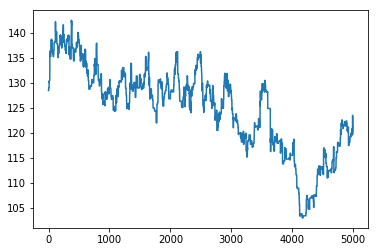

In [35]:
print(scores[-1])
plt.plot(list(range(5000)), scores[-5000:])
plt.show()